# Setup 

In [1]:
# install google chrome
!wget https://dl.google.com/linux/linux_signing_key.pub
!sudo apt-key add linux_signing_key.pub
!echo 'deb [arch=amd64] http://dl.google.com/linux/chrome/deb/ stable main' >> /etc/apt/sources.list.d/google-chrome.list
!sudo apt-get -y update
!sudo apt-get install -y google-chrome-stable
!wget -O /tmp/chromedriver.zip http://chromedriver.storage.googleapis.com/`curl -sS chromedriver.storage.googleapis.com/LATEST_RELEASE`/chromedriver_linux64.zip
!unzip /tmp/chromedriver.zip chromedriver -d /usr/local/bin/

# install selenium
!sudo apt install -y python3-selenium
!pip install selenium==3.141.0 > /dev/null

# To check Google Chrome's version
!google-chrome --version

# To check Chrome Driver's version
!chromedriver -v

# Setup Webdriver
from selenium import webdriver
from selenium.webdriver.common.by import By

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--headless')
chrome_options.add_argument('--disable-gpu')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument("--window-size=1920,1080")
driver = webdriver.Chrome(options=chrome_options)

--2023-08-15 13:29:25--  https://dl.google.com/linux/linux_signing_key.pub
Resolving dl.google.com (dl.google.com)... 142.250.99.136, 142.250.99.91, 142.250.99.190, ...
Connecting to dl.google.com (dl.google.com)|142.250.99.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14605 (14K) [application/octet-stream]
Saving to: ‘linux_signing_key.pub’

linux_signing_key.p 100%[===================>]  14.26K  --.-KB/s    in 0s      

2023-08-15 13:29:25 (47.9 MB/s) - ‘linux_signing_key.pub’ saved [14605/14605]

OK
Get:1 http://dl.google.com/linux/chrome/deb stable InRelease [1825 B]
Get:2 http://packages.cloud.google.com/apt gcsfuse-focal InRelease [5002 B]
Get:3 https://packages.cloud.google.com/apt cloud-sdk InRelease [6361 B]
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Get:5 http://dl.google.com/linux/chrome/deb stable/main amd64 Packages [1091 B]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:7 http://security.ubuntu.com/u

In [2]:
import io
import os 
import csv
import time
import urllib
import datetime
import pandas as pd
from PIL import Image
from io import BytesIO
from tqdm import tqdm
import dateutil.parser
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.support import expected_conditions as EC

# Setup for Google Images Scraping

In [3]:
# Function to Extract Data Sources of Image based on Input Query

def search_google(search_query, num_of_images):
    # driver = webdriver.Chrome(options=chrome_options)
    search_query = "https://www.google.com/search?site=&tbm=isch&source=hp&biw=1873&bih=990&q=" + search_query
    driver.get( search_query )
    
    image_sources = []
    for ith in range(1,num_of_images+1):
        try:
            img_box = driver.find_element_by_xpath('/html/body/div[2]/c-wiz/div[3]/div[1]/div/div/div/div/div[1]/div[1]/span/div[1]/div[1]/div['+str(ith)+']/a[1]/div[1]/img')
            img_box.click()
            time.sleep(2)
            image = driver.find_element_by_xpath('/html/body/div[2]/c-wiz/div[3]/div[2]/div[3]/div[2]/div[2]/div[2]/div[2]/c-wiz/div/div/div/div[3]/div[1]/a/img[1]')
            image_src = image.get_attribute('src')
            image_sources.append( image_src )
        except: 
            print('skipping '+ str(ith)+" iteration of image search")
    
#     # Close the WebDriver
#     driver.quit()

    return image_sources

# search_google(search_query="cats", num_of_images=1)

In [4]:
# Function to Extract Images from their data source files
import urllib.request

user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
headers={'User-Agent':user_agent,} 

def extract_google_images( query, folder_path, num_of_images, image_extension=".png" ):
    # Create Folder
    try: os.mkdir(folder_path) 
    except: pass  
    # Get Source File of Images
    query_processed = modify_query(query=query)
    image_sources = search_google(query_processed,num_of_images)
    # Storing image as jpg or png
    for index, data_src in enumerate(image_sources):
        request=urllib.request.Request(data_src,None,headers) #The assembled request
        with urllib.request.urlopen(request) as response:
            data_temp = response.read()
            with open(folder_path + query + " " + str(index+1) +  image_extension, mode="wb") as file:
                file.write(data_temp)
                
    # print(" Done ")
    return data_temp
    
# Function to print image for given path and filename of image
def show_image(file_path_name):
    image = mpimg.imread(file_path_name)
    plt.imshow(image)
    print(image.shape)
    plt.axis("off")
    plt.show()

In [5]:
def modify_query(query):
    query_processed = query.replace(" ", "+")
    if query_processed[-1]=="+":
        query_processed = query_processed[:-1]
    if query_processed[0]=="+":
        query_processed = query_processed[1:]
    return query_processed

Input Query:  Narendra Modi on France Visit
Modified Query:  Narendra+Modi+on+France+Visit
(2410, 3615, 3)


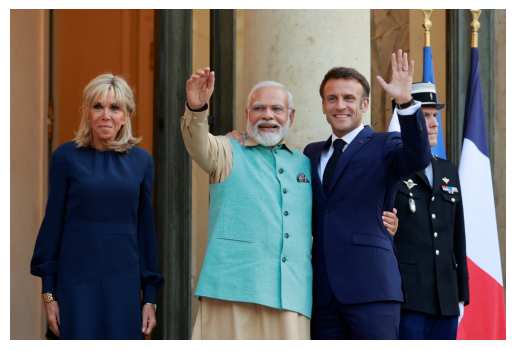

In [6]:
input_query = "Narendra Modi on France Visit"
print('Input Query: ', input_query)
query_processed = modify_query(query=input_query)
print('Modified Query: ', query_processed)
image_data = extract_google_images( query=input_query, folder_path="/kaggle/working/images/", num_of_images=1, image_extension=".jpg" )
show_image( file_path_name='/kaggle/working/images/'+ input_query + ' 1.jpg')

# Scraping Images from Caption Dataset

In [7]:
import re

def remove_numbers_and_punctuation(text):
    # Remove numbers
    text_without_numbers = re.sub(r'\d+', '', text)
    
    # Remove punctuation
    text_without_punctuation = re.sub(r'[^\w\s]', '', text_without_numbers)

    return text_without_punctuation

# Example text
input_text = "Hello! This is an example text with 123 numbers and some punctuation marks!!!"

# Remove numbers and punctuation
cleaned_text = remove_numbers_and_punctuation(input_text)

print("Original Text:", input_text)
print("Cleaned Text:", cleaned_text)

Original Text: Hello! This is an example text with 123 numbers and some punctuation marks!!!
Cleaned Text: Hello This is an example text with  numbers and some punctuation marks


In [8]:
from datasets import Dataset, DatasetDict

data = pd.read_csv("/kaggle/input/captions-dataset/captions_dataset_shirsh.txt", sep="\t", header=None)
data.rename(columns={0:"captions"},inplace=True)
data["captions"] = data["captions"].apply( remove_numbers_and_punctuation  )
# data = data[0:10]
data

,captions
0,A radiant sunrise over the tranquil countryside
1,A group of friends laughing around a campfire
2,An intricate sandcastle on a sunny beach
3,A determined athlete sprinting towards victory
4,A vintage bicycle parked near a quaint bakery
...,...
995,A joyful family having a picnic by a serene lake
996,A contented farmer tending to a field of ripe...
997,A street artist creating a vibrant mural on a...
998,A surfer catching a wave with skill and finesse


In [9]:
for caption in tqdm(data["captions"]):
    try:
        image_data = extract_google_images( query=modify_query(query=caption[1:]), folder_path="/kaggle/working/images/", num_of_images=1, image_extension=".jpg" )
    except:
        pass

 14%|█▍        | 142/1000 [09:50<56:17,  3.94s/it]

skipping 1 iteration of image search


100%|██████████| 1000/1000 [1:04:07<00:00,  3.85s/it]


In [10]:
import os
file_names = [file for file in os.listdir("/kaggle/working/images")]
file_names

['A+street+musician+playing+a+lively+tune+on+a+trumpet 1.jpg',
 'A+serene+lake+surrounded+by+lush+greenery 1.jpg',
 'A+vintage+car+parked+in+front+of+a+historic+building 1.jpg',
 'A+curious+cat+investigating+a+pile+of+leaves 1.jpg',
 'A+majestic+waterfall+surrounded+by+lush+vegetation 1.jpg',
 'A+joyful+family+picnicking+in+a+lush+green+field 1.jpg',
 'A+musician+playing+a+violin+with+emotion+and+finesse 1.jpg',
 'A+cyclist+riding+through+a+picturesque+vineyard 1.jpg',
 'A+talented+musician+playing+a+saxophone+on+a+street+corner 1.jpg',
 'A+joyful+family+enjoying+a+picnic+by+a+calm+lake 1.jpg',
 'A+skilled+potter+shaping+clay+into+intricate+designs 1.jpg',
 'A+surfer+catching+a+wave+as+the+sun+sets 1.jpg',
 'A+group+of+friends+hiking+up+a+steep+mountain+trail 1.jpg',
 'A+cozy+cabin+surrounded+by+snowcovered+trees 1.jpg',
 'The+sun+setting+behind+the+mountains+casting+a+warm+and+golden+glow+over+the+world 1.jpg',
 'A+medieval+castle+against+a+backdrop+of+blue+sky 1.jpg',
 'A+surfer+catc

In [11]:
import numpy as np
from PIL import Image

image_caption_data = {'caption':[], "image_data":[]}
for caption in tqdm(file_names):
    image_caption_data["caption"].append(caption[:-6].replace("+", " "))
    image_data = np.array(Image.open("/kaggle/working/images"+"/"+caption))
    image_caption_data["image_data"].append(image_data)

100%|██████████| 208/208 [00:08<00:00, 24.33it/s]


In [12]:
# def add_image(instance):
#     input_query = instance["captions"]
#     query_processed = modify_query(query=input_query)
#     image_data = extract_google_images( query=query_processed, folder_path="/kaggle/working/images/", num_of_images=1, image_extension=".jpg" )
#     instance["image_data_bytes"] = image_data
#     return instance

In [13]:
data = Dataset.from_dict( image_caption_data )
# data = data.map(add_image,num_proc=1,batched=False)
data.save_to_disk("/kaggle/working/")
data

Dataset({
    features: ['caption', 'image_data'],
    num_rows: 208
})

In [14]:
from huggingface_hub import notebook_login
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
try:
    login(token=user_secrets.get_secret("SHIRSH_HUGGINGFACE_API_KEY"), write_permission=True)
    data.push_to_hub("shirsh10mall/Image_Captioning_Dataset", private=False)
except:
    print("\n\n\n Dataset not uploaded on Hugging Face")

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


Pushing dataset shards to the dataset hub:   0%|          | 0/5 [00:00<?, ?it/s]




 Dataset not uploaded on Hugging Face




 Caption:  A musician playing a violin with emotion and finesse
(520, 780, 3)


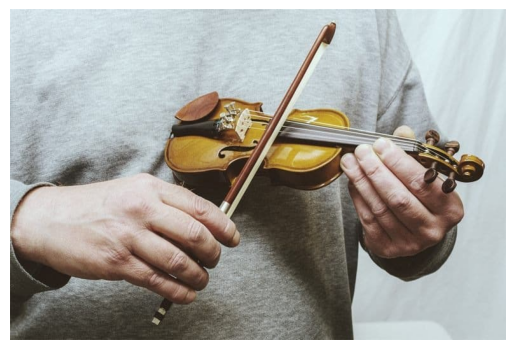

In [15]:
sample = data[6]
print("\n\n Caption: ", sample['caption'])

# Create an Image object from the bytes data
image = np.array(sample["image_data"])

# Display image
plt.imshow(image)
print(image.shape)
plt.axis("off")
plt.show()